# Analyze Covid RBD Data

This tutorial covers a brief example of how to analyze and prepare Alphaseq data for model ingestion. For simplicity, we refer to the Alphaseq log10-$K_d$ as $K_d$.

We cover the following:

- Investigating affinity distributions
- Assessing relative performance of binding
- Pre-processing data for a PPI model 

In [1]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Load the dataset
We fetch an example dataset with `COVID_YM005`. This dataset is a panel of antibodies in 2 orientations against a site-saturation mutagenesis (SSM) of the COVID RBD. In this dataset, the `mata` library are COVID scFv binders, and the `alpha` library are SSMs of the covid RBD. The wildtype "WT" is defined by a canonical sequence of a SARS-Cov-2 RBD.

We load the dataset below:
                           

In [2]:
df = pd.read_csv("hf://datasets/aalphabio/COVID_YM005/YM_005.csv")
df.head()

/home/ubuntu/anaconda3/envs/nsml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


mata_description                                      mata_sequence  \
0        ACE2_Full  QSTIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMN...   
1        ACE2_Full  QSTIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMN...   
2        ACE2_Full  QSTIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMN...   
3        ACE2_Full  QSTIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMN...   
4        ACE2_Full  QSTIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMN...   

  matalpha_description                                  matalpha_sequence  \
0            A157D_GAT  RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...   
1            A157E_GAA  RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...   
2            A157F_TTT  RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...   
3            A157G_GGT  RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...   
4            A157H_CAT  RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...   

   alphaseq_affinity  alphaseq_affinity_lower_bound  \
0                NaN                            NaN   
1                NaN                            NaN   
2                NaN                            NaN   
3            3.61569                       4.293472   
4                NaN                            NaN   

   alphaseq_affinity_upper_bound  
0                       3.727013  
1                       2.634238  
2                       3.964184  
3                       2.937909  
4                       3.865760

For plotting simplicity, we perform a small str change to the description columns to enable easier plotting

In [3]:
df["mata_plot_description"] = df["mata_description"].str.replace("CoV_binder_", "")
df["matalpha_plot_description"] = df["matalpha_description"].apply(
    lambda x: x.split("_")[0].split("|")[0].replace("syn", "")
)
df[["mata_plot_description", "matalpha_plot_description"]].head()

mata_plot_description matalpha_plot_description
0             ACE2_Full                     A157D
1             ACE2_Full                     A157E
2             ACE2_Full                     A157F
3             ACE2_Full                     A157G
4             ACE2_Full                     A157H

## Analyze technical replicates

One of the first things we observe is the affinity of the full distribution, including replicates. This allows us to estimate the upper and lower bounds of the binders.

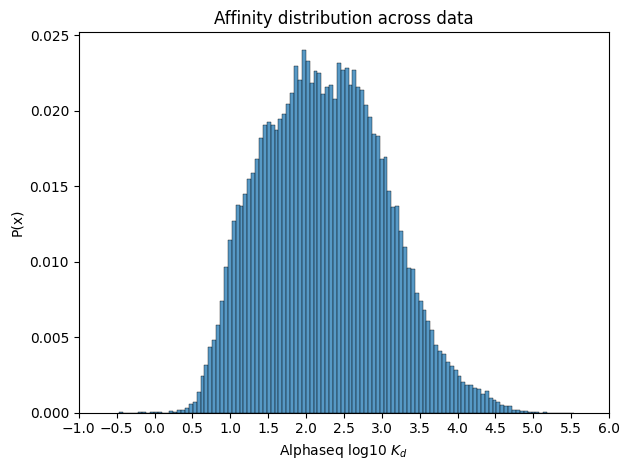

In [4]:
f, ax = plt.subplots(1, 1)
sns.histplot(data=df, x="alphaseq_affinity", ax=ax, stat="probability")
ax.set_xticks(np.arange(-1, 6.1, 0.5))
ax.set_xlabel(r"Alphaseq log10 $K_d$")
ax.set_ylabel("P(x)")
ax.set_title("Affinity distribution across data")
f.tight_layout()

Many of the binders exhibit $K_d < 3$; this suggests (as expected) many of the antibodies tested bind the target of interest.

Next, we want to establish a "baseline" affinity for each binder in reference to the WT antigen. We gather the WT replicates for each unique binder. We observe the distribution as a function of the binders by plotting the `alphaseq_affinity` as a function of `mata_description`.

In [5]:
wt = df[
    (df.matalpha_description.str.contains("WT"))
    | (df.matalpha_description == "SARS-CoV2_RBD_(6LZG)")
].reset_index(drop=True)

print("Number of replicates per binder=", wt.shape[0] / wt.mata_description.nunique())

Number of replicates per binder= 13.0


In [6]:
# sort binder names such that 1_HL/1_LH are partnered together

binders = sorted(
    wt.mata_plot_description.unique(),
    key=lambda s: (
        (m := re.match(r"^(\d+)_([A-Za-z]+)$", s)) is None,
        int(m.group(1)) if m else 0,
        m.group(2).upper() if m else s,
    ),
)

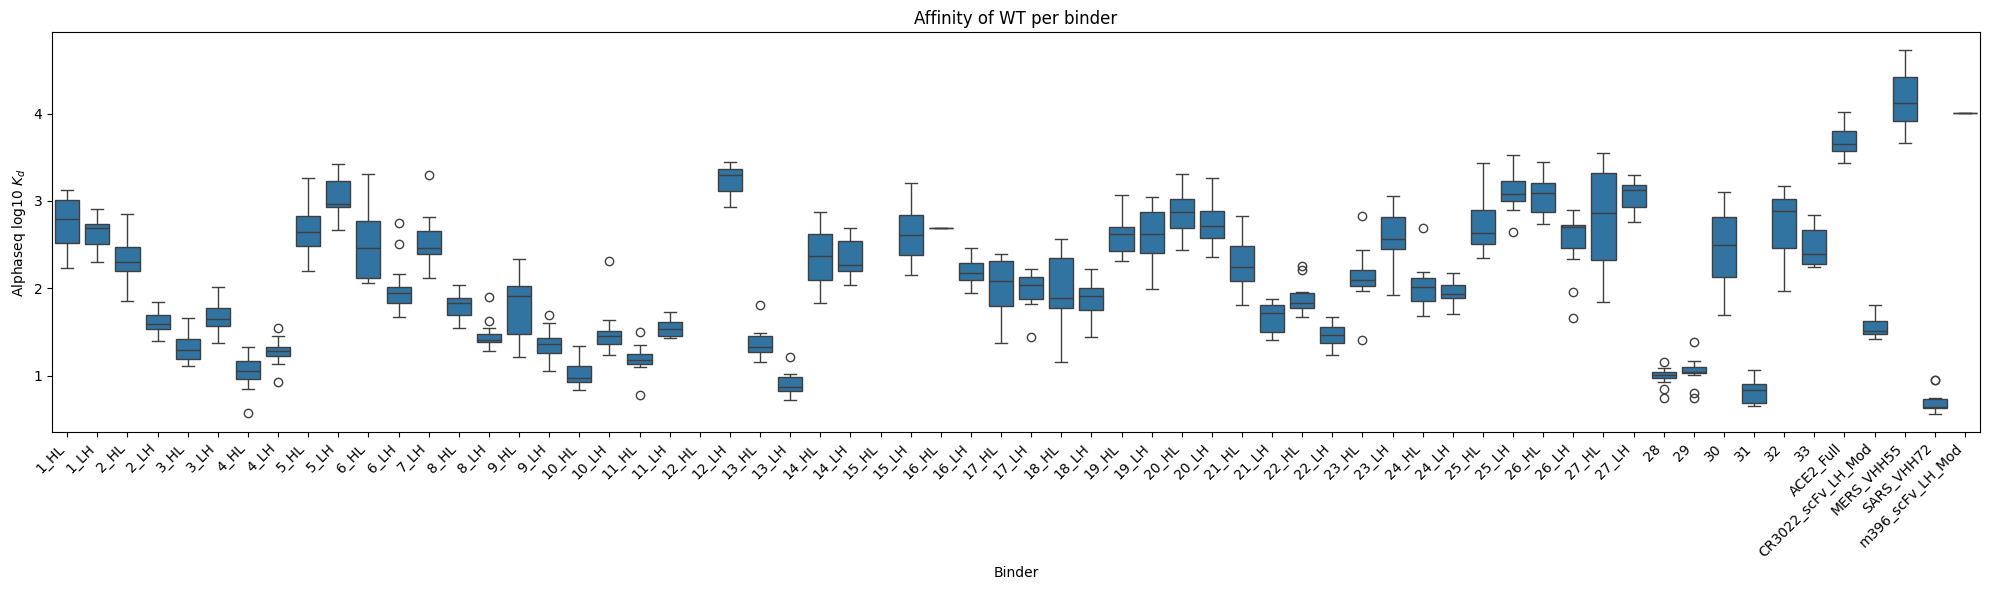

In [7]:
f, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.boxplot(
    data=wt,
    x="mata_plot_description",
    y="alphaseq_affinity",
    ax=ax,
    order=binders,
)
plt.xticks(rotation=45, ha="right")
ax.set_xlabel("Binder")
ax.set_ylabel(r"Alphaseq log10 $K_d$")
ax.set_title("Affinity of WT per binder")
f.tight_layout()

## Clean and prepare data for ML

Our next step is to create an aggregate PPI per unique (`sequence_a`, `sequence_alpha`) pair. To handle technical replicates above, we average affinities across these values. We also minimally clean the dataset to remove NaN values for affinity.

In [8]:
# Drop NaN vlaues
df = df.dropna(subset="alphaseq_affinity").reset_index(drop=True)
ppis = df.groupby(["mata_sequence", "matalpha_sequence"], as_index=False).agg(
    {
        (col if col != "alphaseq_affinity" else "alphaseq_affinity"): (
            "first" if col != "alphaseq_affinity" else "mean"
        )
        for col in df.columns
    }
)
print("Unique A/Alpha pairs", ppis.shape[0])

Unique A/Alpha pairs 90949


With that, our `ppis` dataframe represents minimally ML-ready data if you are interested in PPI sequence to function (affinity) performance.

## Analyze the difference in affinity

We now observe the affinity distribution for all unique PPIs; the replicates hardly affect the bulk distribution

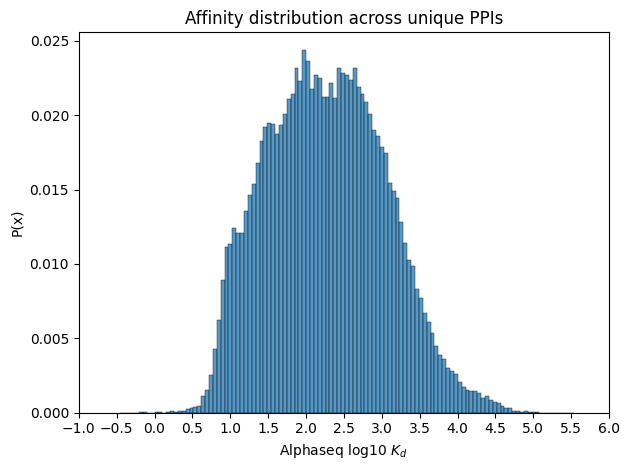

In [9]:
f, ax = plt.subplots(1, 1)
sns.histplot(data=ppis, x="alphaseq_affinity", ax=ax, stat="probability")
ax.set_xticks(np.arange(-1, 6.1, 0.5))
ax.set_xlabel(r"Alphaseq log10 $K_d$")
ax.set_ylabel("P(x)")
ax.set_title("Affinity distribution across unique PPIs")
f.tight_layout()

We now want to compute the $\Delta K_d$, or the difference in binding strength of variants of the RBD to a given binder versus the WT. We use our "wt" dict as a reference per binder. For cases where WT binding is not defined, we make the decision to placehold this value as "NaN" and not make comparisons. 

In [10]:
wtseq = df[df.matalpha_description.str.contains("WT")].matalpha_sequence.iloc[0]

# Get the WT RBD binding to each binder as a reference
wtKd = (
    ppis[ppis.matalpha_sequence == wtseq]
    .set_index("mata_plot_description")["alphaseq_affinity"]
    .to_dict()
)
ppis["ref_aff"] = ppis["mata_plot_description"].apply(lambda x: wtKd.get(x, None))

# Compute the difference in binding affinity between variants and the reference
ppis["delta_aff"] = ppis["alphaseq_affinity"] - ppis["ref_aff"]

For each binder, we now compute the difference in affinity

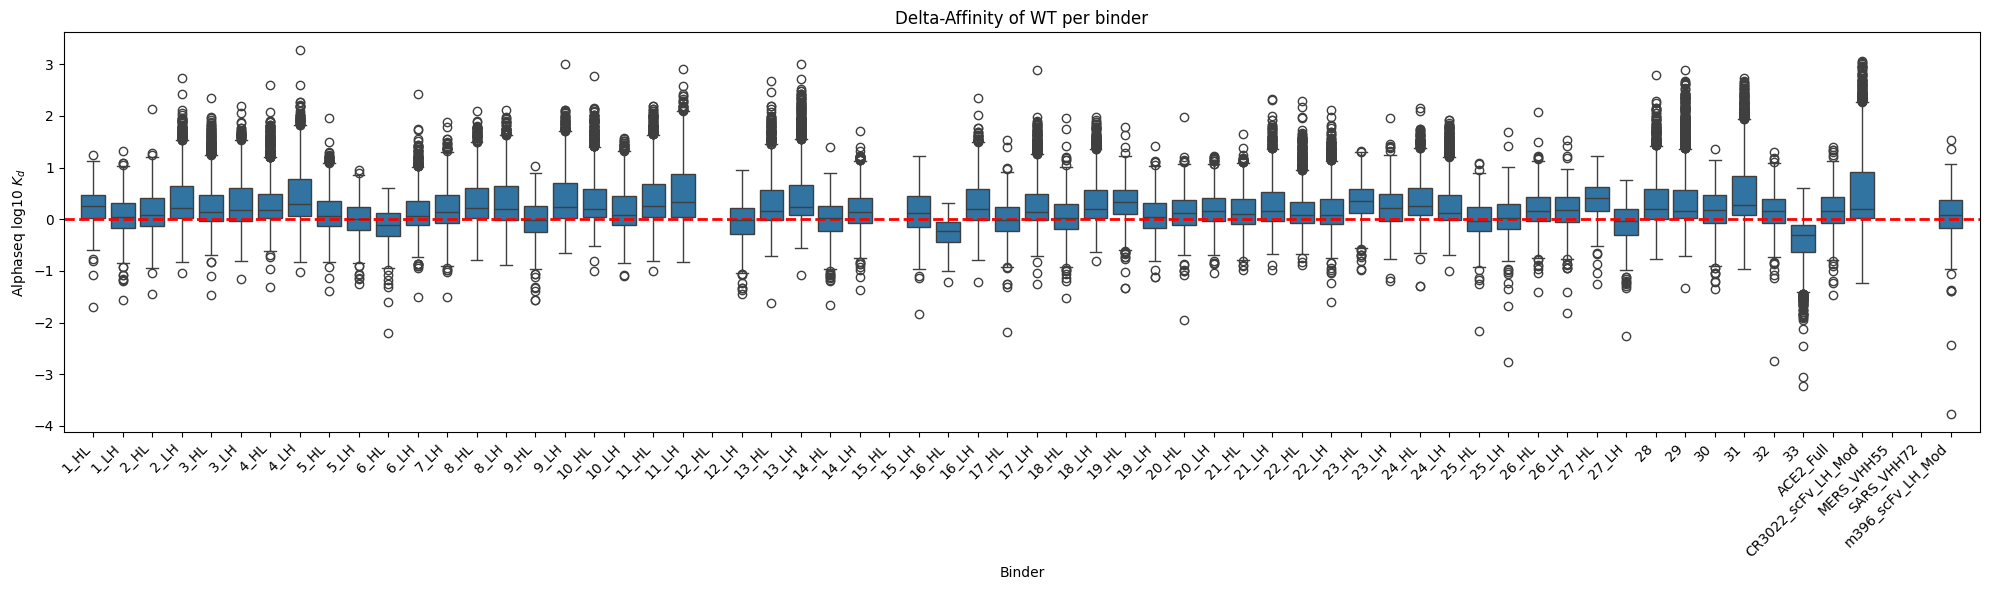

In [11]:
f, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.boxplot(
    data=ppis,
    x="mata_plot_description",
    y="delta_aff",
    ax=ax,
    order=binders,
)
ax.plot(np.arange(-1, 75), np.zeros(76), "r--", linewidth=2)
ax.set_xlim([-1, 64])
plt.xticks(rotation=45, ha="right")
ax.set_xlabel("Binder")
ax.set_ylabel(r"Alphaseq log10 $K_d$")
ax.set_title("Delta-Affinity of WT per binder")
f.tight_layout()

For a given binder, we can also construct heatmaps of the binding changes as a function of mutation. First, we collect the mutations and their positions on the target protein.

In [12]:
# Filter for only mutation data
ppis_filt = ppis[
    ppis["matalpha_plot_description"].astype(str).str.contains(r"\d", na=False)
]
ppis_filt = ppis_filt[
    ~ppis_filt["matalpha_plot_description"].str.contains("SARS")
].reset_index(drop=True)
ppis_filt["position"] = ppis_filt["matalpha_plot_description"].apply(
    lambda x: int(x[1:-1])
)
ppis_filt["mutation"] = ppis_filt["matalpha_plot_description"].apply(lambda x: x[-1])

We plot a heatmap of position to amino-acid to get a rough epitope map

In [13]:
AAs = [
    "A",
    "R",
    "N",
    "D",
    "C",
    "E",
    "Q",
    "G",
    "H",
    "I",
    "L",
    "K",
    "M",
    "F",
    "P",
    "S",
    "T",
    "W",
    "Y",
    "V",
]
BINDER = "1_HL"

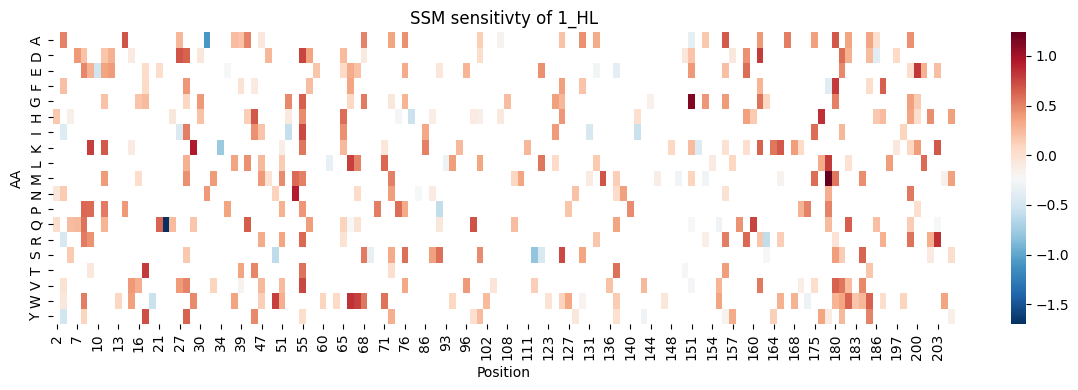

In [14]:
binder_df = ppis_filt[ppis_filt.mata_plot_description == BINDER].reset_index(drop=True)
mat = binder_df.pivot(index="position", columns="mutation", values="delta_aff")
f, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.heatmap(
    data=mat.T,
    ax=ax,
    cmap="RdBu_r",
)
ax.set_xlabel("Position")
ax.set_ylabel("AA")
ax.set_title("SSM sensitivty of " + BINDER)
f.tight_layout()

In general we see for this example binder, that most SSM variants of the RBD actually decrease binding strength to the antibody of interest, highlight potential escape trajectories.

## Conclusion

With that, we have processed a simple example notebook to help navigate the data, learn interesting findings, and prepare the dataset for ML ingestion.